In [3]:
# Install the gensim library
!pip install gensim -q

# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

# --- ROBUST NLTK DOWNLOAD ---
# This ensures all necessary packages for tokenization, stop words, and lemmatization are present.
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab') # Add download for punkt_tab
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')
# --- END OF ROBUST DOWNLOAD ---


# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')


# Load the dataset
file_path = "/content/drive/MyDrive/FakeNewsDetection/WELFake_Dataset.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 52.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Step 2: Data Understanding and Initial Cleaning

Dataset shape: (72134, 4)

Missing values per column:
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

Shape after dropping missing values: (72095, 3)



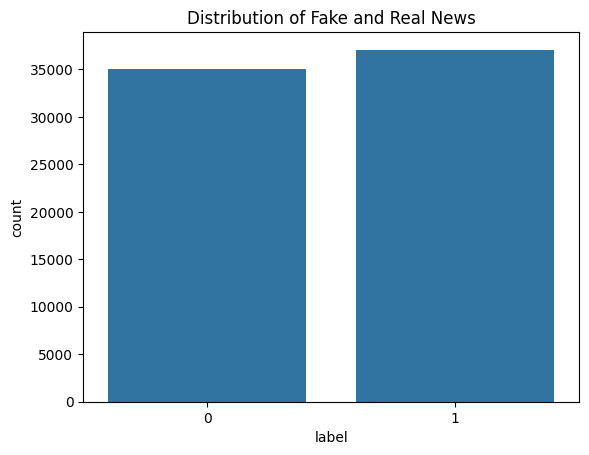

In [4]:
# Get the shape of the dataset
print(f"Dataset shape: {df.shape}\n")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing 'text' or 'label'
df.dropna(subset=['text', 'label'], inplace=True)

# We can also drop the 'Unnamed: 0' column as it's just an index
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

print(f"\nShape after dropping missing values: {df.shape}\n")

# Check the distribution of labels (0 for real, 1 for fake)
sns.countplot(x='label', data=df)
plt.title('Distribution of Fake and Real News')
plt.show()

Step 3: Advanced Text Preprocessing

In [5]:
# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Ensure punkt_tab is downloaded
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ""  # Return an empty string or handle as appropriate
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize and remove stop words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return lemmatized_tokens

# Apply the preprocessing to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)

print("Original Text:\n", df['text'].iloc[0])
print("\nProcessed Text:\n", df['processed_text'].iloc[0])

Original Text:
 No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to

Step 4: Alternative Feature Engineering with Word2Vec

In [6]:
# Train a Word2Vec model on our processed text data
# size: The dimensionality of the word vectors.
# window: The maximum distance between the current and predicted word within a sentence.
# min_count: Ignores all words with a total frequency lower than this.
word2vec_model = Word2Vec(sentences=df['processed_text'], vector_size=100, window=5, min_count=1, workers=4)

# Function to create a document vector by averaging word vectors
def document_vector(doc, model):
    # Filter out words not in the model's vocabulary
    doc = [word for word in doc if word in model.wv.key_to_index]
    if not doc:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# Create document vectors for our dataset
df['doc_vector'] = df['processed_text'].apply(lambda x: document_vector(x, word2vec_model))

# Prepare the data for the machine learning model
X = np.array(df['doc_vector'].tolist())
y = df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (57676, 100)
Shape of X_test: (14419, 100)


Step 5: Model Selection, Training, and Hyperparameter Tuning

In [7]:
# --- REVISED STEP 5: MODEL TRAINING WITH BALANCING ---

# Define the parameter grid (no changes here)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize the Logistic Regression model WITH the class_weight parameter
log_reg = LogisticRegression(random_state=42, class_weight='balanced') # <-- THE FIX IS HERE

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data (this will take a few moments)
print("Starting hyperparameter tuning with balanced class weights...")
grid_search.fit(X_train, y_train)

# Get the best estimator
best_log_reg = grid_search.best_estimator_
print(f"\nBest parameters found: {grid_search.best_params_}")

# IMPORTANT: Now that you have a new 'best_log_reg', you must re-evaluate it
print("\n--- Re-evaluating the new balanced model ---")
y_pred_new = best_log_reg.predict(X_test)
accuracy_new = accuracy_score(y_test, y_pred_new)
print(f"New Test Accuracy: {accuracy_new * 100:.2f}%\n")
print("New Classification Report:")
print(classification_report(y_test, y_pred_new, target_names=['Real (0)', 'Fake (1)']))

Starting hyperparameter tuning with balanced class weights...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

--- Re-evaluating the new balanced model ---
New Test Accuracy: 87.90%

New Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.88      0.88      0.88      7010
    Fake (1)       0.88      0.88      0.88      7409

    accuracy                           0.88     14419
   macro avg       0.88      0.88      0.88     14419
weighted avg       0.88      0.88      0.88     14419



Step 6: Comprehensive Evaluation

Test Accuracy: 87.90%

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.88      0.88      0.88      7010
    Fake (1)       0.88      0.88      0.88      7409

    accuracy                           0.88     14419
   macro avg       0.88      0.88      0.88     14419
weighted avg       0.88      0.88      0.88     14419



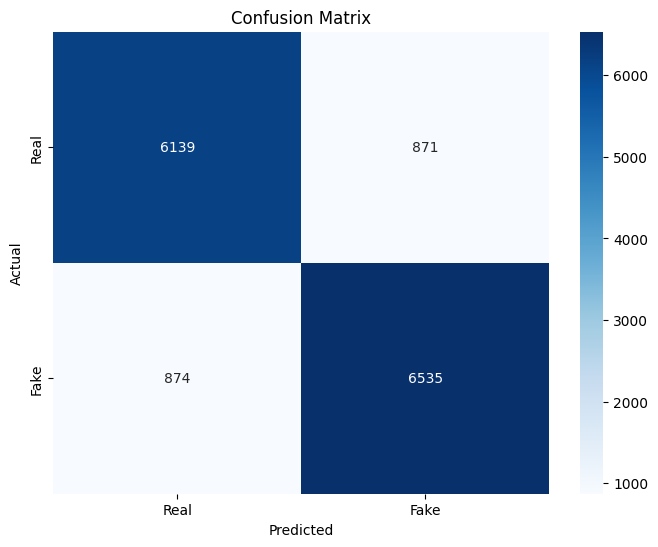

In [8]:
# Make predictions on the test set
y_pred = best_log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%\n")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Step 8: Predicting on New, Unseen Data


In [9]:
# Example of new news articles to classify
new_articles = [
    "The president announced a new groundbreaking policy on climate change today, which is expected to have a major impact.", # Likely Real
    "BREAKING: Scientists have discovered aliens living on Mars, says a source from an anonymous online forum." # Likely Fake
]

# Preprocess the new articles
processed_new_articles = [preprocess_text(article) for article in new_articles]

# Create document vectors for the new articles
new_doc_vectors = [document_vector(doc, word2vec_model) for doc in processed_new_articles]

# Predict the labels
new_predictions = best_log_reg.predict(new_doc_vectors)

# Display the predictions
for article, prediction in zip(new_articles, new_predictions):
    label = "Fake" if prediction == 1 else "Real"
    print(f"Article: \"{article[:50]}...\"\nPredicted Label: {label}\n")

Article: "The president announced a new groundbreaking polic..."
Predicted Label: Real

Article: "BREAKING: Scientists have discovered aliens living..."
Predicted Label: Fake



Step 9: Creating a Simple User Interface with Gradio

In [10]:
# Install the gradio library
!pip install gradio -q

import gradio as gr

In [11]:
# Create a single function that encapsulates the entire prediction pipeline (WITH DEBUGGING)
def predict_news(news_text):
    """
    Takes raw news text and returns a dictionary of prediction probabilities.
    """
    print("--- New Prediction ---")
    print(f"Original Text: '{news_text[:100]}...'") # Print the first 100 chars

    # 1. Preprocess the input text
    processed_text = preprocess_text(news_text)
    print(f"Processed Tokens: {processed_text}")

    # 2. Convert the processed text to a document vector
    # We will use a slightly more robust vector creation function
    doc_vector = document_vector(processed_text, word2vec_model)

    # --- DEBUGGING CHECK ---
    # Check if the vector is all zeros. This is a huge red flag.
    if np.sum(doc_vector) == 0:
        print("WARNING: The generated document vector is all zeros! This means no words from the input were found in the model's vocabulary.")
    else:
        print("Document vector generated successfully.")
    # --- END DEBUGGING ---

    # 3. Reshape for the model
    model_input = np.array(doc_vector).reshape(1, -1)

    # 4. Predict probabilities
    prediction_probabilities = best_log_reg.predict_proba(model_input)

    # 5. Format the output
    output = {
        'Real': float(prediction_probabilities[0][0]),
        'Fake': float(prediction_probabilities[0][1])
    }
    print(f"Prediction Output: {output}\n")
    return output

In [12]:
# Define the input component
input_textbox = gr.Textbox(lines=10, placeholder="Paste a news article here...")

# Define the output component
output_label = gr.Label(num_top_classes=2)

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_news,
    inputs=input_textbox,
    outputs=output_label,
    title="Fake News Detector (Improved Version)",
    description="This model uses Word2Vec, a balanced Logistic Regression classifier, and robust prediction logic.",
    allow_flagging="never"
)

# Launch the interface
iface.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6783dc4506902003f6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


--- New Prediction ---
Original Text: 'Article 1: The "Scientific Breakthrough" Hoax

Headline: Scientists Discover That Drinking a Gallon ...'
Processed Tokens: ['article', 'scientific', 'breakthrough', 'hoax', 'headline', 'scientist', 'discover', 'drinking', 'gallon', 'glacier', 'water', 'daily', 'revers', 'aging', 'source', 'natural', 'health', 'truth', 'daily', 'note', 'source', 'fabricated', 'content', 'groundbreaking', 'study', 'alpine', 'longevity', 'institute', 'fabricated', 'found', 'consuming', 'one', 'gallon', 'pure', 'water', 'melting', 'glacier', 'alp', 'trigger', 'telomere', 'regeneration', 'effectively', 'reversing', 'aging', 'process', 'year', 'elena', 'voss', 'lead', 'researcher', 'stated', 'unique', 'mineral', 'composition', 'frozen', 'millennium', 'act', 'genetic', 'reset', 'button', 'big', 'pharma', 'terrified', 'finding', 'study', 'followed', 'participant', 'one', 'month', 'showed', 'dramatic', 'undeniable', 'result', 'critic', 'point', 'study', 'peer', 'reviewed',